# Exploratory Data Analysis

Loading CSV from: Earthquakes_USGS_from_2000.csv


/var/folders/ns/121v7rc11cs_vj8084rhbnww0000gn/T/ipykernel_91174/1700141424.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)



Dataset shape: 2968711 rows x 30 columns

Sample rows (first 5):
           id   mag                                  place                     time                  updated  tz  \
0  nc21075020   NaN     26 km SE of Tres Pinos, California  2000-01-01 08:01:56.840  2016-12-31 11:48:45.599 NaN   
1   ci9131988  0.80           18km W of Ludlow, California  2000-01-01 08:02:46.200  2016-02-17 10:17:42.228 NaN   
2   ci9521550  0.70           32km S of Ludlow, California  2000-01-01 08:03:08.000  2016-02-16 07:49:36.754 NaN   
3  nc21075021  1.23  5 km NE of East Foothills, California  2000-01-01 08:03:53.650  2016-12-31 11:48:51.007 NaN   
4  usp0009kjv  1.90         7 km W of Porirua, New Zealand  2000-01-01 08:04:49.400  2014-11-07 09:09:13.881 NaN   

                                                 url                                             detail  felt  cdi  mmi alert    status  tsunami  sig net  \
0  https://earthquake.usgs.gov/earthquakes/eventp...  https://earthquake.usgs.go

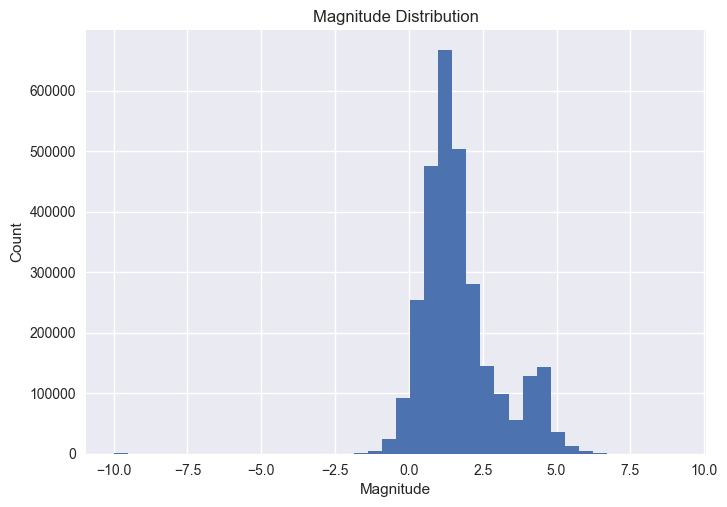

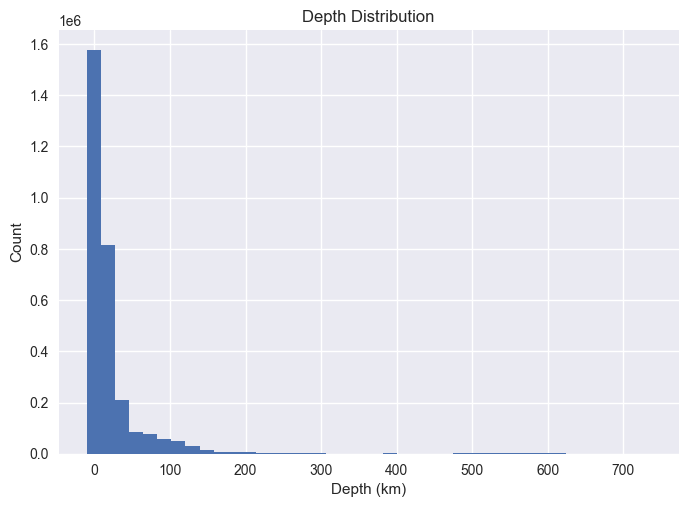

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Customise your own path here!
CSV_PATH = r"Earthquakes_USGS_from_2000.csv"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Loading CSV
print(f"Loading CSV from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

print(f"\nDataset shape: {df.shape[0]} rows x {df.shape[1]} columns")

# Printing some rows
print("\nSample rows (first 5):")
print(df.head(5))

# We dug for missing values so printing them out
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    print("\nColumns with missing values (top 15):")
    print(missing.head(15))
else:
    print("\nNo missing values detected.")

colnames = {c.lower(): c for c in df.columns}

mag_col   = colnames.get("mag") or None
depth_col = colnames.get("depth") or None
lat_col   = colnames.get("latitude") or colnames.get("lat")
lon_col   = colnames.get("longitude") or colnames.get("lon") or colnames.get("long")
place_col = colnames.get("place")

# Try to detect and parse a datetime column
parsed_time_col = None

for c in df.columns:
    if c.lower() in ("time", "date", "datetime", "timestamp"):
        df[c + "_parsed"] = pd.to_datetime(df[c], errors="coerce", utc=True)
        parsed_time_col = c + "_parsed"
        print(f"\nParsed datetime from '{c}' into '{parsed_time_col}'")
        break

if parsed_time_col is None:
    for c in df.columns:
        if df[c].dtype == object and df[c].str.contains(r"\d{4}-\d{2}-\d{2}", na=False).any():
            df[c + "_parsed"] = pd.to_datetime(df[c], errors="coerce", utc=True)
            parsed_time_col = c + "_parsed"
            print(f"\nAuto-parsed datetime-like column '{c}' into '{parsed_time_col}'")
            break

# Summary for columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    print("\nNumeric column summary:")
    print(df[num_cols].describe().T)


# Showing some cool notable events!
if mag_col:
    print("\nTop 10 events by magnitude:")
    cols = [c for c in [mag_col, depth_col, lat_col, lon_col, place_col] if c]
    print(df.nlargest(10, mag_col)[cols])

if depth_col:
    print("\nTop 10 deepest events:")
    cols = [c for c in [depth_col, mag_col, lat_col, lon_col, place_col] if c]
    print(df.nlargest(10, depth_col)[cols])

if parsed_time_col:
    print("\nMost recent 10 events:")
    cols = [c for c in [parsed_time_col, mag_col, depth_col, place_col, lat_col, lon_col] if c]
    print(df.sort_values(parsed_time_col, ascending=False).head(10)[cols])

# Plotting section

# Magnitude histogram
if "mag" in df.columns:
    plt.figure()
    df["mag"].dropna().hist(bins=40)
    plt.title("Magnitude Distribution")
    plt.xlabel("Magnitude")
    plt.ylabel("Count")
    plt.show()

# Depth histogram
if "depth" in df.columns:
    plt.figure()
    df["depth"].dropna().hist(bins=40)
    plt.title("Depth Distribution")
    plt.xlabel("Depth (km)")
    plt.ylabel("Count")
    plt.show()


# Cleaning + Extended EDA

Rows after cleaning: 2805526

Remaining Columns:
['id', 'mag', 'place', 'time', 'updated', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'magType', 'type_property', 'title', 'longitude', 'latitude', 'depth', 'time_parsed', 'year', 'month', 'day', 'hour', 'country']

Basic Statistics:
               count        mean        std       min         25%         50%         75%      max
mag        2805526.0    1.743385   1.292969   -0.9900    0.890000    1.400000    2.260000    8.800
depth      2805526.0   24.317611  55.479316    0.0000    3.691000    8.450000   17.980000  700.000
latitude   2805526.0   38.112978  20.989726  -84.4220   33.705167   38.503833   52.605175   87.386
longitude  2805526.0 -103.992086  77.773510 -179.9997 -149.275475 -120.521667 -115.801167  180.000

Top inferred regions:
inferred_country
Alaska              769781
CA                  514425
California          434268
Nevada              171643
Hawaii              130878
Pue

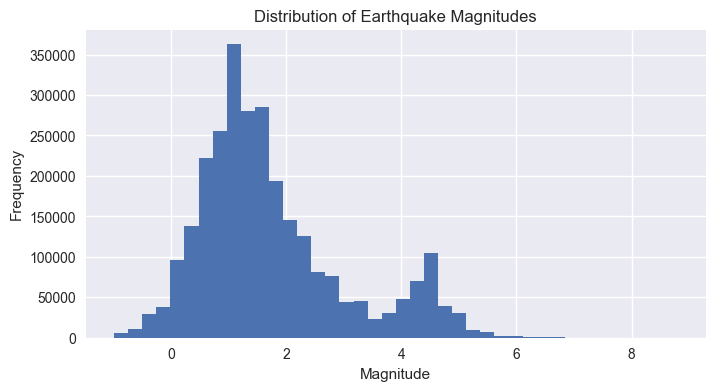

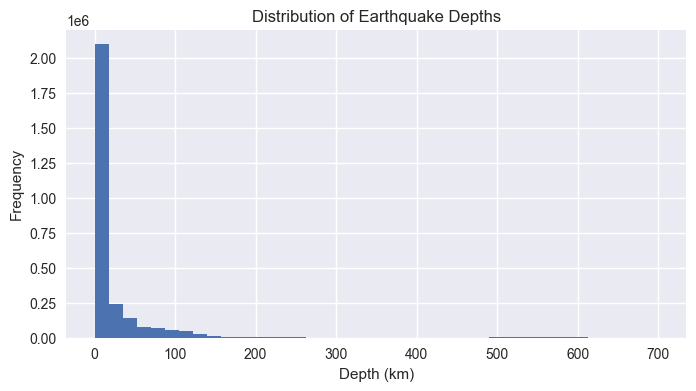

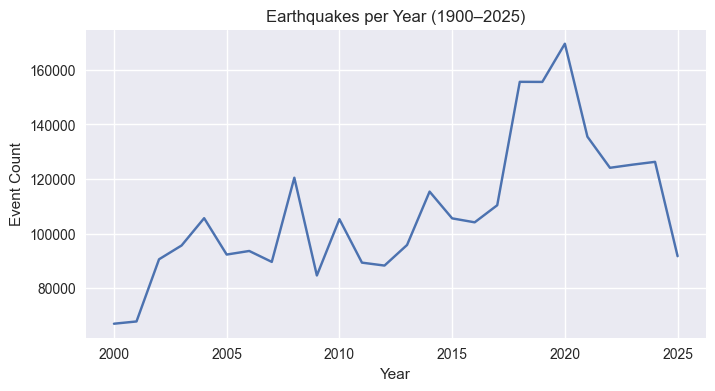

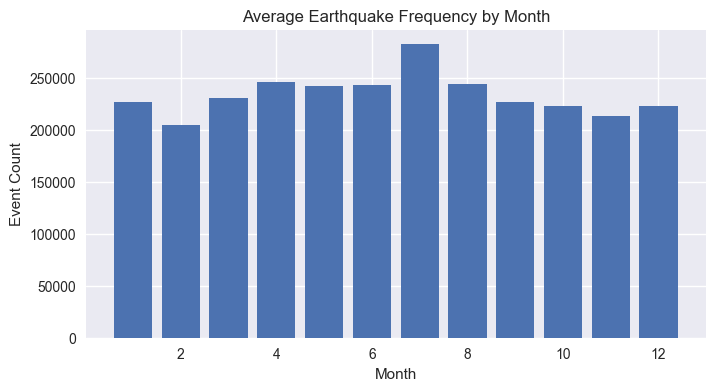

In [ ]:
# Cleaning and Extended EDA

# Drop columns with no info or irrelevant info
cols_to_drop = [
    'tz', 'url', 'detail', 'ids', 'sources', 'types', 'code', 'net'
]
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors='ignore')

# Drop rows with missing core info
core_cols = ['mag', 'latitude', 'longitude', 'depth', 'time']
df.dropna(subset=[c for c in core_cols if c in df.columns], inplace=True)

df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)
df = df[df['time'].notna()]

# Add time-derived columns
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour

# Clean place column
if 'place' in df.columns:
    df['place'] = df['place'].fillna('Unknown')
    def extract_country(s):
        if pd.isna(s):
            return None
        parts = [p.strip() for p in str(s).split(',')]
        if len(parts) > 1:
            return parts[-1]
        m = re.search(r"\(([^)]+)\)", s)
        if m:
            return m.group(1).strip()
        return s
    df['country'] = df['place'].apply(extract_country)

# Removing invalid or outlier magnitudes/depths
df = df[(df['mag'] > -1) & (df['mag'] <= 9)]
df = df[(df['depth'] >= 0) & (df['depth'] <= 700)]

print("Rows after cleaning:", len(df))
print("\nRemaining Columns:")
print(df.columns.tolist())
print("\nBasic Statistics:")
print(df[['mag', 'depth', 'latitude', 'longitude']].describe().T)

# Inferring region from place text (very primitive grouping)
if place_col:
    def extract_country(s):
        if pd.isna(s):
            return None
        s = str(s)
        parts = [p.strip() for p in s.split(",")]
        if len(parts) > 1:
            return parts[-1]
        m = re.search(r"\(([^)]+)\)", s)
        return m.group(1).strip() if m else None

    df["inferred_country"] = df[place_col].apply(extract_country)
    print("\nTop inferred regions:")
    print(df["inferred_country"].value_counts().head(20))


# Visualising some graphs to figure out the data
plt.rcParams['figure.figsize'] = (8,4)

# 1. Magnitude distribution
plt.figure()
df['mag'].hist(bins=40)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

# 2. Depth distribution
plt.figure()
df['depth'].hist(bins=40)
plt.title('Distribution of Earthquake Depths')
plt.xlabel('Depth (km)')
plt.ylabel('Frequency')
plt.show()

# 3. Events per year
yearly = df['year'].value_counts().sort_index()
plt.figure()
plt.plot(yearly.index, yearly.values)
plt.title('Earthquakes per Year (1900–2025)')
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.show()

# 4. Events by month (aggregated over all years)
plt.figure()
month_counts = df['month'].value_counts().sort_index()
plt.bar(month_counts.index, month_counts.values)
plt.title('Average Earthquake Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.show()


# Geospatial + Magnitude–Depth Analysis

Starting geospatial analysis...


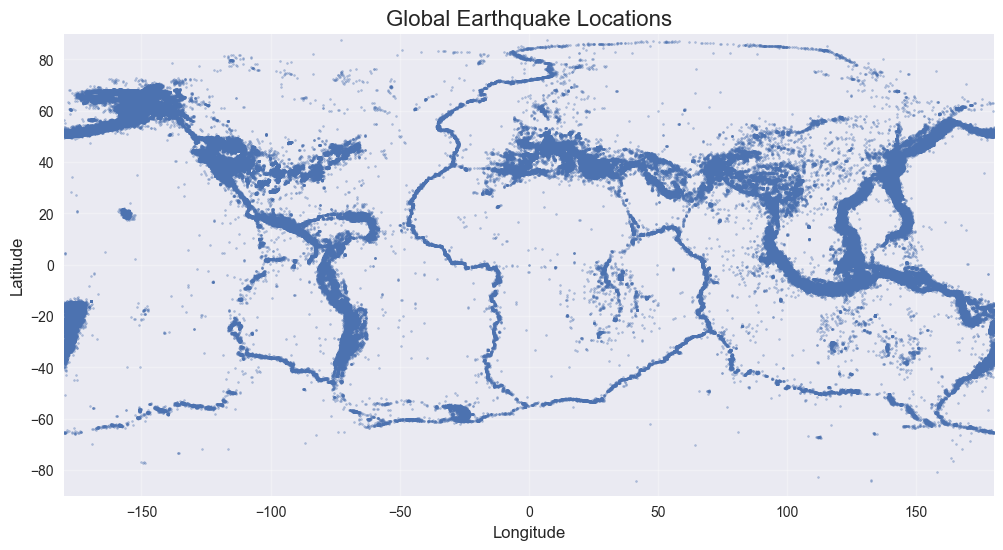

Global Earthquake Density Heatmap (high-activity zones shown in red)



DBSCAN clustering on coordinates


127.0.0.1 - - [24/Nov/2025 21:35:59] "GET /earthquake_map.html HTTP/1.1" 200 -


Identified 1 clusters.


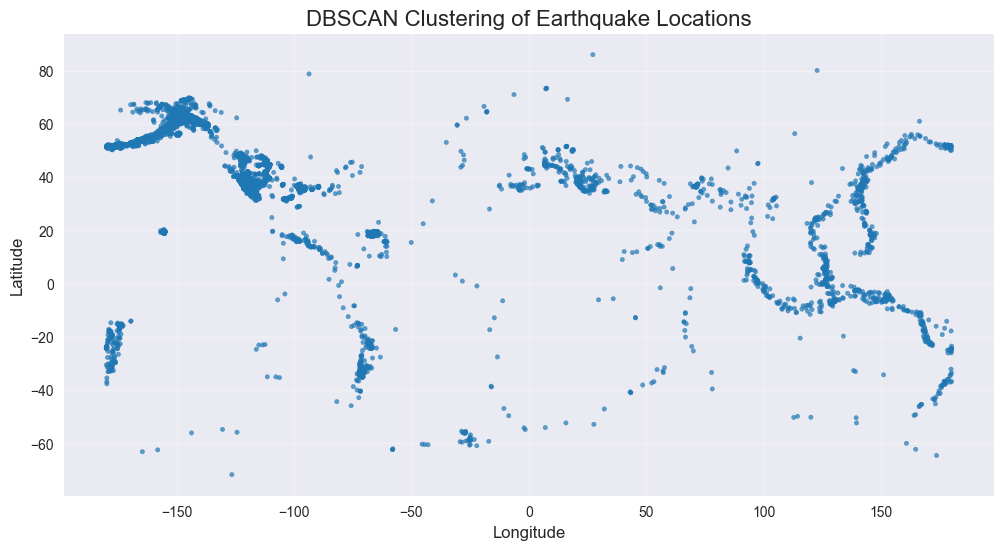


Analyzing magnitude and depth relationships...

Correlation matrix:
            mag     depth
mag    1.000000  0.349634
depth  0.349634  1.000000


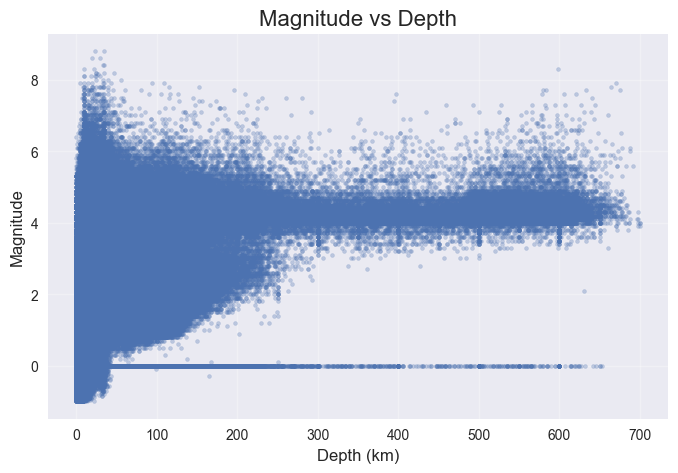

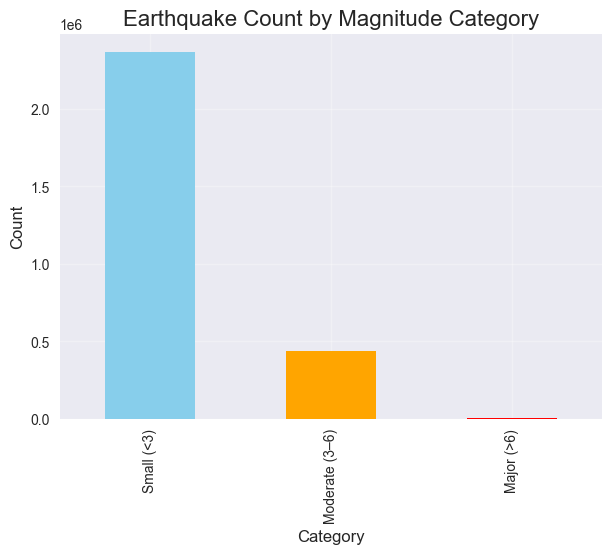

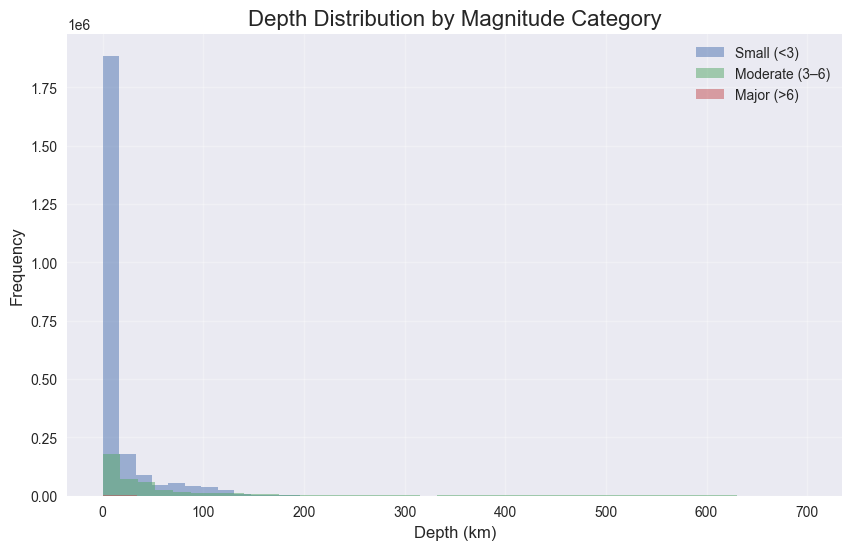

In [19]:
#   Geospatial + Magnitude–Depth Analysis starts here

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import os
import socket, threading, http.server, socketserver
from IPython.display import IFrame, HTML, display

plt.style.use("seaborn-v0_8")  

print("Starting geospatial analysis...")

# 1. Global Scatter Plot
plt.figure(figsize=(12, 6))
plt.scatter(df['longitude'], df['latitude'], s=2, alpha=0.4)
plt.title("Global Earthquake Locations", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()

# 2. Folium Interactive map
print("Global Earthquake Density Heatmap (high-activity zones shown in red)")
world_map = folium.Map(
    location=[0, 0],
    zoom_start=2,
    tiles="CartoDB positron"
)

heat_data = df[['latitude', 'longitude']].dropna()
if len(heat_data) > 10000:
    heat_data = heat_data.sample(10000, random_state=42)

HeatMap(heat_data).add_to(world_map)

# Save the map as usual
map_filename = "earthquake_map.html"
world_map.save(map_filename)

# Find a free localhost port
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind(("", 0))
port = sock.getsockname()[1]
sock.close()

# Serve the current working directory so the map file can be loaded
handler = http.server.SimpleHTTPRequestHandler
httpd = socketserver.TCPServer(("", port), handler)

server_thread = threading.Thread(target=httpd.serve_forever, daemon=True)
server_thread.start()

# Display the map through an iframe (bypasses trust restrictions)
display(IFrame(f"http://localhost:{port}/{map_filename}", width=900, height=500))


# 3. DBSCAN Clustering
print("\nDBSCAN clustering on coordinates")

coords = df[['latitude', 'longitude']].dropna()
if len(coords) > 10000:
    coords = coords.sample(10000, random_state=42)

db = DBSCAN(
    eps=1.5,
    min_samples=50,
    metric="haversine"
).fit(np.radians(coords))

coords["cluster"] = db.labels_
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Identified {n_clusters} clusters.")

# Plot clusters
plt.figure(figsize=(12, 6))
mask = coords["cluster"] != -1
plt.scatter(
    coords.loc[mask, "longitude"],
    coords.loc[mask, "latitude"],
    c=coords.loc[mask, "cluster"],
    s=10,
    cmap="tab20",
    alpha=0.7,
)
plt.title("DBSCAN Clustering of Earthquake Locations", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 4. Magnitude & Depth relationships
print("\nAnalyzing magnitude and depth relationships...")

corr = df[['mag', 'depth']].corr()
print("\nCorrelation matrix:")
print(corr)

plt.figure(figsize=(8, 5))
plt.scatter(df["depth"], df["mag"], alpha=0.3, s=8)
plt.title("Magnitude vs Depth", fontsize=16)
plt.xlabel("Depth (km)", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Magnitude categories
bins = [-1, 3, 6, 9]
labels = ["Small (<3)", "Moderate (3–6)", "Major (>6)"]
df["mag_category"] = pd.cut(df["mag"], bins=bins, labels=labels)

plt.figure(figsize=(7, 5))
df["mag_category"].value_counts().reindex(labels).plot(
    kind="bar",
    color=["skyblue", "orange", "red"]
)
plt.title("Earthquake Count by Magnitude Category", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
for label, color in zip(labels, ["blue", "orange", "red"]):
    subset = df[df["mag_category"] == label]
    plt.hist(subset["depth"], bins=40, alpha=0.5, label=label)

plt.title("Depth Distribution by Magnitude Category", fontsize=16)
plt.xlabel("Depth (km)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Gutenberg-Richter and Aftershock Analysis


Estimated a-value: 8.747, b-value: 0.860


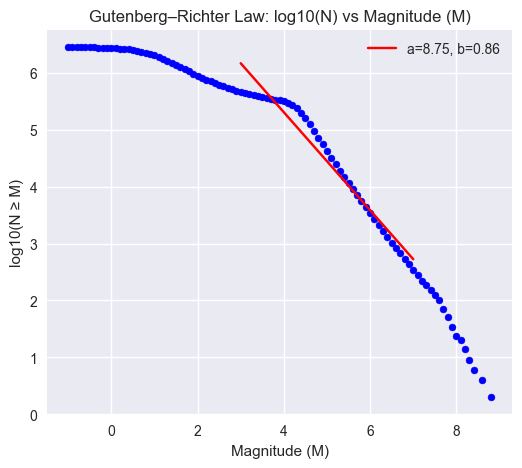

Performing aftershock analysis...


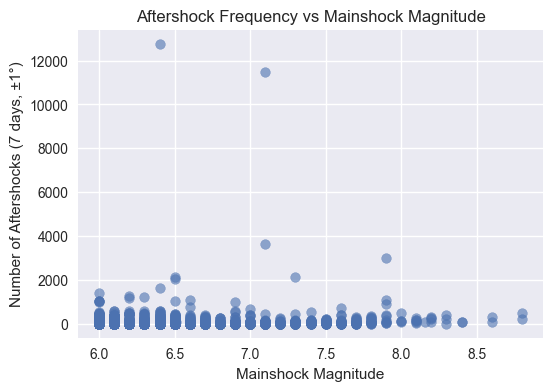

               lat          lon          mag  aftershock_count
count  3452.000000  3452.000000  3452.000000       3452.000000
mean      0.721238    44.843670     6.374789         49.092700
std      29.736172   123.617390     0.427782        326.248939
min     -69.773900  -179.989000     6.000000          0.000000
25%     -19.387625   -72.469925     6.100000          1.000000
50%      -4.031000   109.722150     6.200000          4.000000
75%      23.843275   146.713150     6.500000         22.000000
max      84.948000   179.998100     8.800000      12767.000000


In [12]:
# Gutenberg-Richter and Aftershock Analysis

# The Gutenberg–Richter relationship: log10(N) = a - b*M where N = number of earthquakes ≥ magnitude M

mag_counts = df['mag'].round(1).value_counts().sort_index(ascending=True)
cum_counts = mag_counts[::-1].cumsum()[::-1]  # cumulative number ≥ M

M_values = cum_counts.index.values
N_values = cum_counts.values

plt.figure(figsize=(6,5))
plt.scatter(M_values, np.log10(N_values), s=25, color='blue')
plt.title('Gutenberg–Richter Law: log10(N) vs Magnitude (M)')
plt.xlabel('Magnitude (M)')
plt.ylabel('log10(N ≥ M)')

# Fit a linear regression to estimate b-value
mask = (M_values >= 3) & (M_values <= 7)
if mask.sum() > 5:
    coef = np.polyfit(M_values[mask], np.log10(N_values[mask]), 1)
    a_val, b_val = coef[1], -coef[0]
    plt.plot(M_values[mask], np.polyval(coef, M_values[mask]), color='red', label=f'a={a_val:.2f}, b={b_val:.2f}')
    plt.legend()
    print(f"Estimated a-value: {a_val:.3f}, b-value: {b_val:.3f}")
else:
    print("Not enough data in magnitude range 3–7 for regression.")

plt.show()

# Aftershock Analysis
# Identify mainshocks (mag ≥ 6) and look for nearby events in time and space.
print("Performing aftershock analysis...")

from datetime import timedelta

aftershock_results = []
mainshocks = df[df['mag'] >= 6]

for idx, main in mainshocks.iterrows():
    time_window = timedelta(days=7)  # 1 week after mainshock
    lat, lon, t_main = main['latitude'], main['longitude'], main['time']

    # Define a rough radius (degrees) ~1 deg ≈ 111 km
    nearby = df[(df['time'] > t_main) & (df['time'] <= t_main + time_window)]
    nearby = nearby[(np.abs(nearby['latitude'] - lat) <= 1) & (np.abs(nearby['longitude'] - lon) <= 1)]

    aftershock_count = len(nearby)
    aftershock_results.append((t_main, lat, lon, main['mag'], aftershock_count))

aftershock_df = pd.DataFrame(aftershock_results, columns=['mainshock_time', 'lat', 'lon', 'mag', 'aftershock_count'])

plt.figure(figsize=(6,4))
plt.scatter(aftershock_df['mag'], aftershock_df['aftershock_count'], alpha=0.6)
plt.title('Aftershock Frequency vs Mainshock Magnitude')
plt.xlabel('Mainshock Magnitude')
plt.ylabel('Number of Aftershocks (7 days, ±1°)')
plt.show()

print(aftershock_df.describe())

In [ ]:
# Find the earthquake with maximum aftershock count
max_aftershock_idx = aftershock_df['aftershock_count'].idxmax()
max_aftershock_row = aftershock_df.loc[max_aftershock_idx]

print("Earthquake with maximum aftershock count:")
print(f"  Time: {max_aftershock_row['mainshock_time']}")
print(f"  Location: {max_aftershock_row['lat']:.4f}, {max_aftershock_row['lon']:.4f}")
print(f"  Magnitude: {max_aftershock_row['mag']}")
print(f"  Aftershock count (7 days, ±1°): {max_aftershock_row['aftershock_count']}")

# Get the original event details from df
mainshock_time = max_aftershock_row['mainshock_time']
mainshock_lat = max_aftershock_row['lat']
mainshock_lon = max_aftershock_row['lon']

# Find in original df
original_event = df[
    (df['time'] == mainshock_time) & 
    (df['latitude'] == mainshock_lat) & 
    (df['longitude'] == mainshock_lon)
]
print("\nOriginal event details:")
print(original_event[['time', 'mag', 'place', 'latitude', 'longitude', 'depth']].to_string())

# Also check what's happening in that ±1° box during the 7 days
from datetime import timedelta
nearby_events = df[
    (df['time'] > mainshock_time) & 
    (df['time'] <= mainshock_time + timedelta(days=7)) &
    (np.abs(df['latitude'] - mainshock_lat) <= 1) &
    (np.abs(df['longitude'] - mainshock_lon) <= 1)
]

print(f"\n{len(nearby_events)} events in the ±1° box during 7 days:")
print(f"  Magnitude range: {nearby_events['mag'].min():.1f} to {nearby_events['mag'].max():.1f}")
print(f"  Number of M≥4: {len(nearby_events[nearby_events['mag'] >= 4])}")
print(f"  Number of M≥5: {len(nearby_events[nearby_events['mag'] >= 5])}")

# Check if there are OTHER M≥6 events in this box (multiple mainshocks!)
other_big_events = nearby_events[nearby_events['mag'] >= 6]
print(f"\nOther M≥6 events in same box/time: {len(other_big_events)}")
if len(other_big_events) > 0:
    print(other_big_events[['time', 'mag', 'place']].to_string())

# Statistical Modeling and Hypothesis Testing


python(91992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


                            OLS Regression Results                            
Dep. Variable:                    mag   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 2.714e+06
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:22:34   Log-Likelihood:            -1.2502e+06
No. Observations:             1957148   AIC:                         2.500e+06
Df Residuals:                 1957141   BIC:                         2.501e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8605      0.001    578.016      0.0

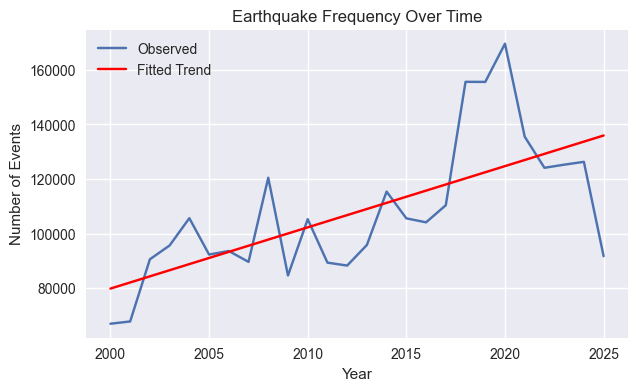

Frequency change test: t = -4.181, p = 4.813e-04
Magnitude difference (Japan vs California): t = 679.820, p = 0.000e+00
Mean annual earthquake rate: 107904.85


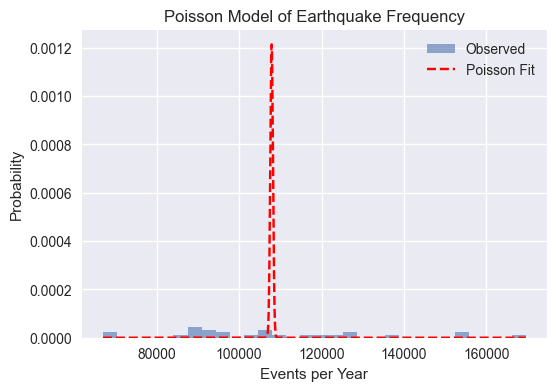

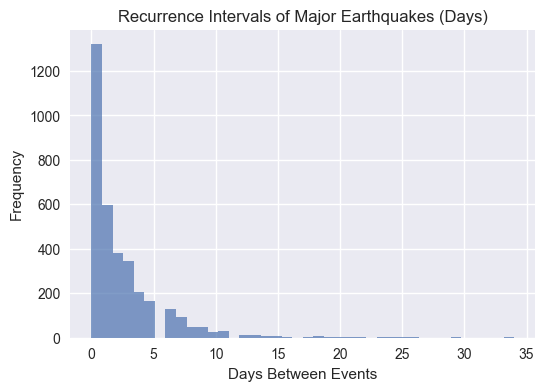

Average recurrence interval: 2.3 days, median: 1.0 days


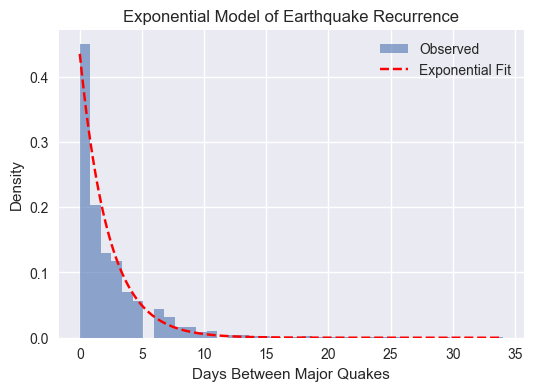

In [13]:
# Statistical Modeling and Hypothesis Testing starts here

import statsmodels.api as sm
from scipy import stats

# Regression Analysis: Predict Magnitude from Other Variables

# Selecting predictors (hardcoding it here)
features = ['depth', 'sig', 'rms', 'gap', 'latitude', 'longitude']
X = df[features].copy()
y = df['mag']
X = sm.add_constant(X)

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

# Regression: Earthquake Frequency Over Time

yearly_counts = df['year'].value_counts().sort_index()
years = yearly_counts.index.values
counts = yearly_counts.values

X_time = sm.add_constant(years)
model_time = sm.OLS(counts, X_time).fit()
print(model_time.summary())

plt.figure(figsize=(7,4))
plt.plot(years, counts, label='Observed')
plt.plot(years, model_time.predict(X_time), color='red', label='Fitted Trend')
plt.title('Earthquake Frequency Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.legend()
plt.show()

# Hypothesis Testing

# 1. Seeing how earthquake frequency has changed over time
first_half = counts[:len(counts)//2]
second_half = counts[len(counts)//2:]
t_stat, p_val = stats.ttest_ind(first_half, second_half, equal_var=False)
print(f"Frequency change test: t = {t_stat:.3f}, p = {p_val:.3e}")

# 2. Comparing earthquake characteristics between two major regions
regions = ['Japan', 'California']
subsets = [df[df['country'].str.contains(r, case=False, na=False)] for r in regions]
if len(subsets[0]) > 0 and len(subsets[1]) > 0:
    t_mag, p_mag = stats.ttest_ind(subsets[0]['mag'], subsets[1]['mag'], equal_var=False)
    print(f"Magnitude difference (Japan vs California): t = {t_mag:.3f}, p = {p_mag:.3e}")
else:
    print("Insufficient data for Japan/California comparison.")

# Probability Models Start here

# 1. Poisson model for annual counts
mean_rate = np.mean(counts)
print(f"Mean annual earthquake rate: {mean_rate:.2f}")

plt.figure(figsize=(6,4))
plt.hist(counts, bins=30, density=True, alpha=0.6, label='Observed')
x_vals = np.arange(min(counts), max(counts)+1)
poisson_probs = stats.poisson.pmf(x_vals, mean_rate)
plt.plot(x_vals, poisson_probs, 'r--', label='Poisson Fit')
plt.title('Poisson Model of Earthquake Frequency')
plt.xlabel('Events per Year')
plt.ylabel('Probability')
plt.legend()
plt.show()

# 2. Recurrence interval estimation for major quakes (mag >= 6)
major_quakes = df[df['mag'] >= 6].sort_values('time')
intervals = major_quakes['time'].diff().dropna().dt.days

plt.figure(figsize=(6,4))
plt.hist(intervals, bins=40, alpha=0.7)
plt.title('Recurrence Intervals of Major Earthquakes (Days)')
plt.xlabel('Days Between Events')
plt.ylabel('Frequency')
plt.show()

mean_interval = intervals.mean()
median_interval = intervals.median()
print(f"Average recurrence interval: {mean_interval:.1f} days, median: {median_interval:.1f} days")

# Fit exponential distribution to recurrence intervals
params = stats.expon.fit(intervals, floc=0)
plt.figure(figsize=(6,4))
plt.hist(intervals, bins=40, density=True, alpha=0.6, label='Observed')
x = np.linspace(0, intervals.max(), 200)
plt.plot(x, stats.expon.pdf(x, *params), 'r--', label='Exponential Fit')
plt.title('Exponential Model of Earthquake Recurrence')
plt.xlabel('Days Between Major Quakes')
plt.ylabel('Density')
plt.legend()
plt.show()

# Some Advanced Statistical Techniques

Starting advanced statistical techniques with adaptive sampling (fixed)...
Available RAM: 0.30 GB — Sampling 10000 points for analysis
Spatio-temporal clusters found: 5


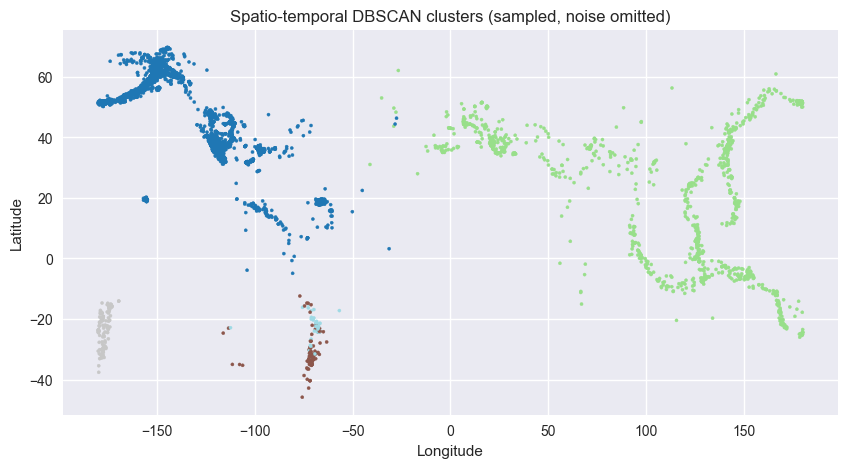

Available RAM: 0.30 GB — Sampling 50000 points for analysis


python(92029) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KMeans clusters created successfully.
Cluster centers (original scale):
        mag       depth        rms         sig
0  1.528498   41.668061   0.586037   40.196067
1  2.153535   11.825404   0.215272   75.141637
2  4.452272   46.877775   0.870168  311.706794
3  4.306941  480.949380   0.791757  291.804772
4  0.766024    6.220833   0.113843   12.495377
5  5.400000    4.957000  69.320000  449.000000
Available RAM: 0.31 GB — Sampling 50000 points for analysis
Explained variance ratios (PCA): [0.46784594 0.19103743 0.1110223 ]


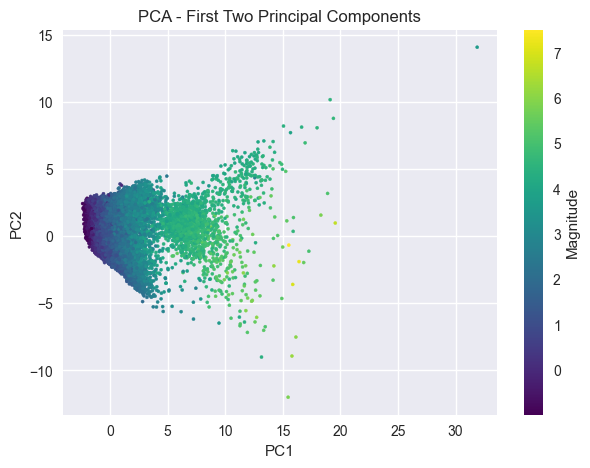

/var/folders/ns/121v7rc11cs_vj8084rhbnww0000gn/T/ipykernel_91174/4289435912.py:83: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('time').resample('M').size()


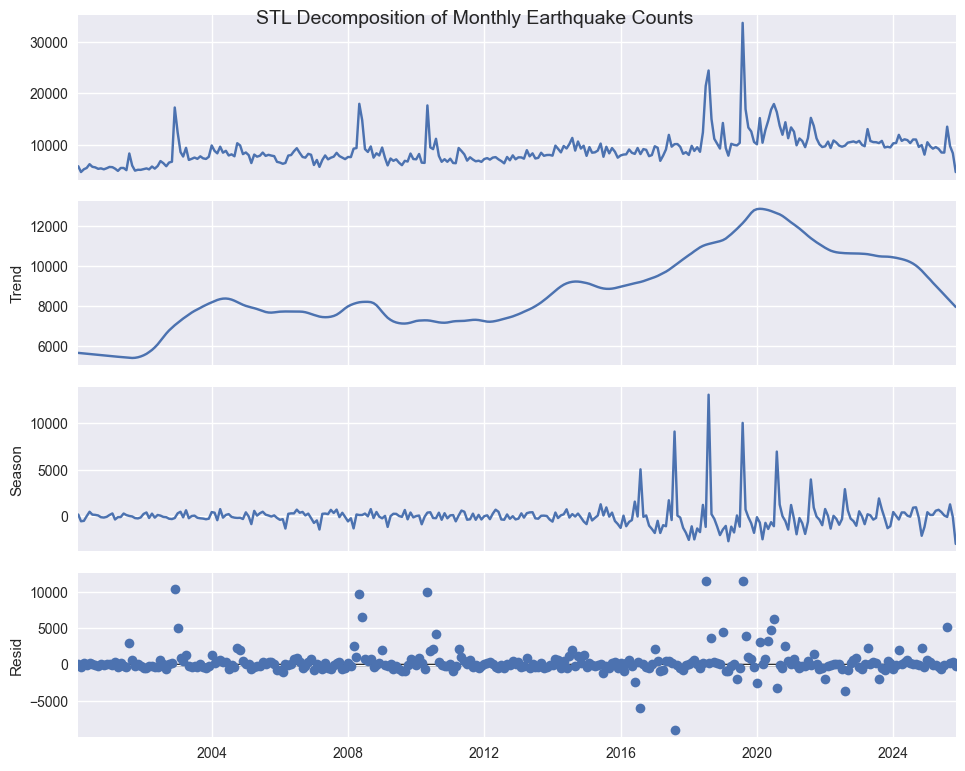

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  286
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2503.136
Date:                            Mon, 24 Nov 2025   AIC                           5016.273
Time:                                    21:22:55   BIC                           5034.302
Sample:                                01-31-2000   HQIC                          5023.511
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8353      0.065     12.923      0.000       0.709       0.962
ma.L1         -0.4467      0.085   

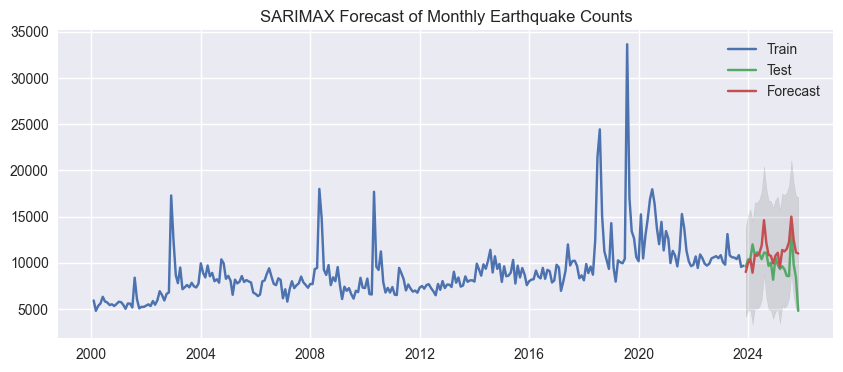

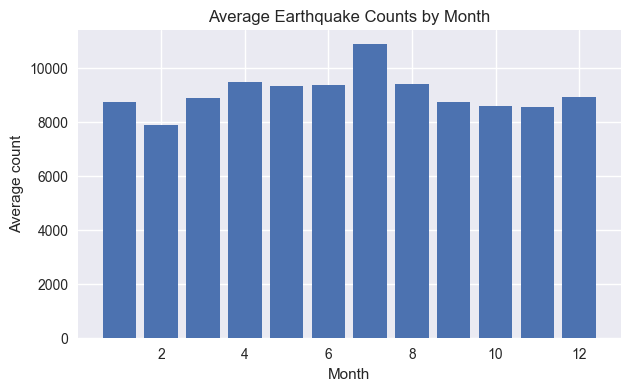

In [14]:
# Advanced Statistical Techniques with Adaptive Sampling

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import psutil

print('Starting advanced statistical techniques with adaptive sampling (fixed)...')

# --- Adaptive sampling function ---
def adaptive_sample(df, max_points_target=10000):
    available_gb = psutil.virtual_memory().available / (1024**3)
    safe_points = int(min(len(df), max_points_target * max(1, available_gb)))
    sample_n = min(len(df), safe_points)
    print(f"Available RAM: {available_gb:.2f} GB — Sampling {sample_n} points for analysis")
    return df.sample(sample_n, random_state=42)

# --- 1) Spatio-temporal clustering ---
coords_time = df[['latitude', 'longitude', 'time']].dropna().copy()
coords_time['time_days'] = (coords_time['time'] - pd.Timestamp('1970-01-01', tz='UTC')) / pd.Timedelta(days=1)
coords_time = adaptive_sample(coords_time, 10000)

st = StandardScaler()
X_st = st.fit_transform(coords_time[['latitude', 'longitude', 'time_days']])

try:
    dbst = DBSCAN(eps=0.6, min_samples=30)
    labels_st = dbst.fit_predict(X_st)
    coords_time['cluster_st'] = labels_st
    print('Spatio-temporal clusters found:', len(set(labels_st)) - (1 if -1 in labels_st else 0))
    plt.figure(figsize=(10,5))
    mask = coords_time['cluster_st'] != -1
    plt.scatter(coords_time.loc[mask, 'longitude'], coords_time.loc[mask, 'latitude'], c=coords_time.loc[mask, 'cluster_st'], s=5, cmap='tab20')
    plt.title('Spatio-temporal DBSCAN clusters (sampled, noise omitted)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
except MemoryError:
    print('DBSCAN memory error — skipping spatio-temporal clustering.')

# 2) KMeans clustering for similar events
features_k = ['mag', 'depth', 'rms', 'sig']
K_df = df[features_k].dropna()
K_df = adaptive_sample(K_df, 50000)

scaler_k = StandardScaler()
K_st = scaler_k.fit_transform(K_df)

try:
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
    kmeans.fit(K_st)
    K_df['kcluster'] = kmeans.labels_
    centers = scaler_k.inverse_transform(kmeans.cluster_centers_)
    centers_df = pd.DataFrame(centers, columns=features_k)
    print('KMeans clusters created successfully.')
    print('Cluster centers (original scale):')
    print(centers_df)
except MemoryError:
    print('KMeans memory error — skipping event grouping.')

# 3) PCA for dimensionality reduction
pca_features = ['mag', 'depth', 'rms', 'gap', 'sig', 'nst', 'dmin']
pca_df = df[pca_features].dropna()
pca_df = adaptive_sample(pca_df, 50000)

scaler = StandardScaler()
X_pca = scaler.fit_transform(pca_df)
pca = PCA(n_components=3, random_state=1)
pcs = pca.fit_transform(X_pca)

print('Explained variance ratios (PCA):', pca.explained_variance_ratio_)
plt.figure(figsize=(7,5))
plt.scatter(pcs[:,0], pcs[:,1], c=pca_df['mag'], s=5, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 4) Time Series Forecasting
monthly = df.set_index('time').resample('M').size()
monthly.index = pd.DatetimeIndex(monthly.index)

# STL Decomposition
stl = STL(monthly, period=12, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(10, 8) 
plt.suptitle('STL Decomposition of Monthly Earthquake Counts', fontsize=14)
plt.show()

# SARIMAX Model
train = monthly[:-24]
test = monthly[-24:]
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
res_sar = model.fit(disp=False)
print(res_sar.summary())

pred = res_sar.get_forecast(steps=24)
pred_ci = pred.conf_int()

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Forecast')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.1)
plt.legend()
plt.title('SARIMAX Forecast of Monthly Earthquake Counts')
plt.show()

# 5) Seasonal Analysis 
monthly_month = monthly.groupby(monthly.index.month).mean()
plt.figure(figsize=(7,4))
plt.bar(range(1,13), monthly_month.values)
plt.xlabel('Month')
plt.ylabel('Average count')
plt.title('Average Earthquake Counts by Month')
plt.show()

# Regional Magnitude Completeness and Omori Productivity with Bootstrap


Regions found: ['Other']

Mc estimation complete (4 records, 14.3s)


,region,type,n,mc_maxcurv,mc_linearity,r2_linearity,mc_maxcurv_CI,mc_linearity_CI,period
0,Other,region_all,200000,1.1,4.15,0.993726,"(1.1, 1.1)","(3.95, 4.2525)",NaN
1,Other,decade,907619,1.1,4.15,NaN,NaN,NaN,2000.0
2,Other,decade,1125499,1.1,4.15,NaN,NaN,NaN,2010.0
3,Other,decade,772408,1.1,4.05,NaN,NaN,NaN,2020.0


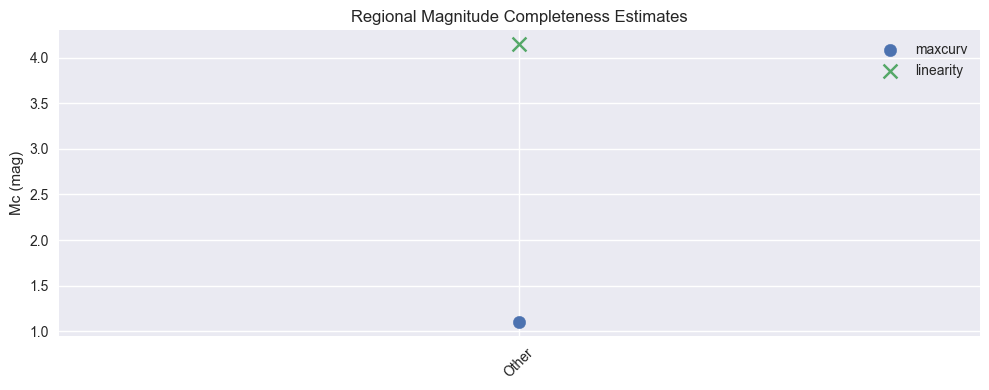


Omori productivity estimation complete (1 regions)


,region,n_mainshocks,K,c,p,K_CI,p_CI
0,Other,178,3563.938511,0.128038,0.74018,"(3391.9890878908254, 4493.14023100634)","(0.4658114193349219, 1.0604452335650747)"


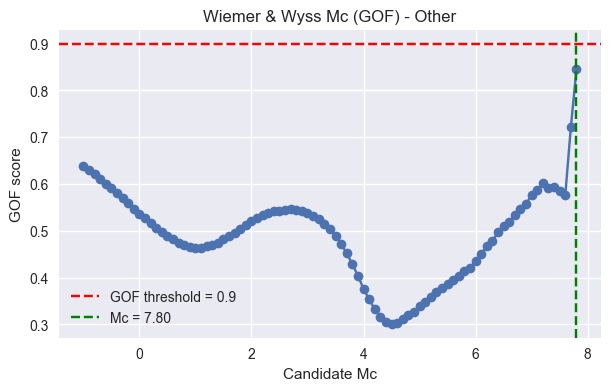


Best Wiemer & Wyss Mc for Other: 7.80

Outputs:
 - mc_df : Mc estimates + CIs
 - prod_df : Omori productivity (K,c,p) + CIs
 - wiemer_wyss_mc() : Mc via formal GOF test


In [15]:
# Mc estimation + Omori productivity + Wiemer & Wyss GOF
from scipy.optimize import curve_fit
from scipy.stats import linregress, ks_2samp
import warnings, time

np.random.seed(42)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# user tweakables
mag_bin_width = 0.1
mag_min, mag_max = -1.0, 9.0
min_mag_bins_for_fit = 5
min_events_region = 200
min_events_year = 100
min_events_decade = 300

mainshock_mag_threshold = 5.5
aftershock_time_days = 30
aftershock_space_deg = 1.0
max_mainshocks_per_region = 200
min_aftershocks_to_fit = 20

mc_bootstrap_iters = 200
omori_bootstrap_iters = 200
max_region_mags_for_MC = 200000
max_stack_aftershocks = 20000

# basic Mc (max curvature)
def maxcurvature_mc(mags, bin_width=0.1):
    bins = np.arange(np.floor(mag_min), np.ceil(mag_max)+bin_width, bin_width)
    h, edges = np.histogram(mags, bins=bins)
    if h.sum() == 0:
        return np.nan
    idx = np.argmax(h)
    return float(np.round(edges[idx], 2))

# cum-dist helper
def compute_cumulative_counts(mags, bin_width=0.1):
    bins = np.arange(np.floor(mag_min), np.ceil(mag_max)+bin_width, bin_width)
    counts, edges = np.histogram(mags, bins=bins)
    mids = edges[:-1] + bin_width / 2
    cum = np.array([counts[i:].sum() for i in range(len(counts))])
    return mids, cum

# Mc via GR linearity search
def linearity_mc(mags, bin_width=0.1, min_bins=5):
    mids, cum = compute_cumulative_counts(mags, bin_width=bin_width)
    valid = cum > 0
    mids, cum = mids[valid], cum[valid]
    if len(mids) < min_bins:
        return maxcurvature_mc(mags), np.nan

    best_r2, best_mc = -np.inf, None
    for i in range(0, len(mids)-min_bins+1):
        x, y = mids[i:], np.log10(cum[i:])
        slope, intercept, r, p, std = linregress(x, y)
        if r**2 > best_r2:
            best_r2, best_mc = r**2, mids[i]

    return float(np.round(best_mc, 2)), float(best_r2)

# Omori rate model
def omori_rate(t, K, c, p):
    t = np.asarray(t)
    return K / np.power(np.maximum(1e-12, c) + np.maximum(1e-12, t), p)

# Omori fit helper
def fit_omori(times_days, initial_guess=(10,0.1,1.0),
              bounds=((1e-6,1e-6,0.1),(1e6,100,3))):

    times = np.asarray(times_days)
    times = times[times >= 0]
    if len(times) < min_aftershocks_to_fit:
        raise RuntimeError("Not enough aftershock samples")

    # log bins for rate estimate
    try:
        bins = np.logspace(np.log10(1e-3 + times.min()), np.log10(max(1.0,times.max())), num=30)
    except ValueError:
        bins = np.logspace(-3, 1, num=30)

    hist, edges = np.histogram(times, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    widths = edges[1:] - edges[:-1]
    rates = hist / widths
    mask = rates > 0

    x, y = centers[mask], rates[mask]
    if len(x) < 5:
        raise RuntimeError("Insufficient data for Omori fit")

    popt, pcov = curve_fit(omori_rate, x, y, p0=initial_guess,
                           bounds=bounds, maxfev=20000)
    return popt, pcov

# region field check
if 'region_continent' not in df.columns:
    df['region_continent'] = 'Other'

regions = df['region_continent'].unique().tolist()
print("Regions found:", regions)

# Mc estimation
mc_records = []
start = time.time()

for region in regions:
    sub = df.loc[df['region_continent']==region].copy()
    if len(sub) < min_events_region:
        continue

    mags = sub['mag'].values
    if len(mags) > max_region_mags_for_MC:
        mags = np.random.choice(mags, size=max_region_mags_for_MC, replace=False)

    mc_max = maxcurvature_mc(mags)
    try:
        mc_lin, r2 = linearity_mc(mags)
    except Exception:
        mc_lin, r2 = np.nan, np.nan

    rec = {
        'region':region,
        'type':'region_all',
        'n':len(mags),
        'mc_maxcurv':mc_max,
        'mc_linearity':mc_lin,
        'r2_linearity':r2
    }

    # bootstrap CIs for Mc
    B = mc_bootstrap_iters
    boots_max, boots_lin = [], []
    for _ in range(B):
        smpl = np.random.choice(mags, size=len(mags), replace=True)
        boots_max.append(maxcurvature_mc(smpl))
        try:
            ml,_ = linearity_mc(smpl)
            boots_lin.append(ml)
        except Exception:
            boots_lin.append(np.nan)

    boots_max, boots_lin = np.array(boots_max), np.array(boots_lin)
    rec['mc_maxcurv_CI'] = (np.nanpercentile(boots_max,2.5),
                            np.nanpercentile(boots_max,97.5))
    rec['mc_linearity_CI'] = (np.nanpercentile(boots_lin,2.5),
                              np.nanpercentile(boots_lin,97.5))

    mc_records.append(rec)

    # decade splits
    sub['decade'] = (sub['year']//10)*10
    for dec, cnt in sub['decade'].value_counts().sort_index().items():
        if cnt < min_events_decade:
            continue
        mags_d = sub.loc[sub['decade']==dec,'mag'].values
        mc_d = maxcurvature_mc(mags_d)
        try:
            ml_d,_ = linearity_mc(mags_d)
        except Exception:
            ml_d = np.nan

        mc_records.append({
            'region':region,
            'type':'decade',
            'period':int(dec),
            'n':cnt,
            'mc_maxcurv':mc_d,
            'mc_linearity':ml_d
        })

mc_df = pd.DataFrame(mc_records)
print(f"\nMc estimation complete ({len(mc_df)} records, {time.time()-start:.1f}s)")
display(mc_df.head(10))

# plot region Mc
plt.figure(figsize=(10,4))
plt.scatter(mc_df[mc_df['type']=='region_all']['region'],
            mc_df[mc_df['type']=='region_all']['mc_maxcurv'], label='maxcurv', s=80)
plt.scatter(mc_df[mc_df['type']=='region_all']['region'],
            mc_df[mc_df['type']=='region_all']['mc_linearity'], label='linearity',
            marker='x', s=100)
plt.ylabel('Mc (mag)')
plt.title('Regional Magnitude Completeness Estimates')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Omori productivity
prod_records = []
for region in regions:
    sub = df.loc[df['region_continent']==region].sort_values('time').copy()
    if len(sub) < min_events_region:
        continue

    mains = sub.loc[sub['mag']>=mainshock_mag_threshold]\
              .sort_values('time',ascending=False)\
              .head(max_mainshocks_per_region)
    if len(mains)==0:
        continue

    stacked_times, counts = [], []
    for _, main in mains.iterrows():
        t0, lat0, lon0 = main['time'], main['latitude'], main['longitude']

        # nearby events in time + space
        mask_time = (sub['time']>t0) & (sub['time']<=t0+pd.Timedelta(days=aftershock_time_days))
        mask_spat = (np.abs(sub['latitude']-lat0)<=aftershock_space_deg) & \
                    (np.abs(sub['longitude']-lon0)<=aftershock_space_deg)

        after = sub.loc[mask_time & mask_spat & (sub['time']>t0)]
        if after.empty:
            continue

        t_days = (after['time']-t0).dt.total_seconds()/86400
        stacked_times += list(t_days)
        counts.append(len(after))

    if len(stacked_times) < min_aftershocks_to_fit:
        continue
    if len(stacked_times) > max_stack_aftershocks:
        stacked_times = list(np.random.choice(stacked_times,
                                               size=max_stack_aftershocks,
                                               replace=False))

    try:
        popt,_ = fit_omori(np.array(stacked_times), initial_guess=(np.mean(counts),0.1,1.0))
        K_est,c_est,p_est = map(float,popt)
    except Exception as e:
        print(f"Omori fit failed for {region}: {e}")
        continue

    rec = {
        'region':region,
        'n_mainshocks':len(counts),
        'K':K_est,
        'c':c_est,
        'p':p_est
    }

    # bootstrap CIs
    bootK, bootp = [], []
    for _ in range(omori_bootstrap_iters):
        boot = np.random.choice(stacked_times, size=len(stacked_times), replace=True)
        try:
            pb,_ = fit_omori(np.array(boot), initial_guess=(np.mean(counts),0.1,1.0))
            bootK.append(pb[0])
            bootp.append(pb[2])
        except Exception:
            bootK.append(np.nan)
            bootp.append(np.nan)

    rec['K_CI'] = (np.nanpercentile(bootK,2.5), np.nanpercentile(bootK,97.5))
    rec['p_CI'] = (np.nanpercentile(bootp,2.5), np.nanpercentile(bootp,97.5))

    prod_records.append(rec)

prod_df = pd.DataFrame(prod_records)
print(f"\nOmori productivity estimation complete ({len(prod_df)} regions)")
display(prod_df)

# Wiemer & Wyss GOF Mc
def wiemer_wyss_mc(mags, threshold_range=None, bin_width=0.1, gof_threshold=0.9):
    mags = np.sort(mags)
    if threshold_range is None:
        threshold_range = np.arange(np.floor(mags.min()),
                                    np.ceil(mags.max())-0.5, 0.1)

    gof_scores = []
    for mc in threshold_range:
        M_sel = mags[mags >= mc]
        if len(M_sel) < 50:
            gof_scores.append(np.nan)
            continue

        # GR b-value via MLE
        b = (np.log10(np.e)) / (np.mean(M_sel) - (mc - bin_width/2))

        # predicted GR curve
        M_pred = np.linspace(mc, M_sel.max(), 100)
        N_pred = 10 ** (-b * (M_pred - mc))

        # empirical CDF
        ecdf_y = np.arange(1, len(M_sel)+1)[::-1] / len(M_sel)
        ecdf_x = np.sort(M_sel)

        # KS distance -> GOF
        gof = 1 - ks_2samp(ecdf_y, N_pred[:len(ecdf_y)])[0]
        gof_scores.append(gof)

    gof_scores = np.array(gof_scores)
    good = np.where(gof_scores >= gof_threshold)[0]
    best_mc = threshold_range[good[0]] if len(good)>0 else threshold_range[np.nanargmax(gof_scores)]
    return best_mc, gof_scores, threshold_range

# demo plot on first region
sample_region = mc_df.iloc[0]['region']
sample_mags = df.loc[df['region_continent']==sample_region, 'mag'].values

mc_wiemer, gof_scores, thr = wiemer_wyss_mc(sample_mags)

plt.figure(figsize=(7,4))
plt.plot(thr, gof_scores, '-o')
plt.axhline(0.9, color='r', linestyle='--', label='GOF threshold = 0.9')
plt.axvline(mc_wiemer, color='g', linestyle='--', label=f'Mc = {mc_wiemer:.2f}')
plt.title(f"Wiemer & Wyss Mc (GOF) - {sample_region}")
plt.xlabel("Candidate Mc"); plt.ylabel("GOF score")
plt.legend()
plt.show()

print(f"\nBest Wiemer & Wyss Mc for {sample_region}: {mc_wiemer:.2f}")

# final outputs
print("\nOutputs:")
print(" - mc_df : Mc estimates + CIs")
print(" - prod_df : Omori productivity (K,c,p) + CIs")
print(" - wiemer_wyss_mc() : Mc via formal GOF test")


# Declustering Eartchquake Sequences with Hawkes temporal model, ETAS-like temporal model (with magnitude) and Omori Sequence Analysis


In [16]:
# Code 1: utilities and model functions

from scipy.optimize import minimize, curve_fit
from pandas.api.types import is_datetime64_any_dtype
from numba import njit


# Helper: haversine
def haversine_km(lat1, lon1, lat2, lon2):
    """Vectorized haversine distance in kilometers."""
    lat1, lon1, lat2, lon2 = map(np.asarray, (lat1, lon1, lat2, lon2))
    lat1r, lon1r, lat2r, lon2r = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2r - lat1r
    dlon = lon2r - lon1r
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1r) * np.cos(lat2r) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(np.clip(a, 0, 1)))
    return 6371.0088 * c


# Hawkes and ETAS negative loglikelihoods (Numba only)
@njit
def _hawkes_neg_loglik_numba(params, times_days, T):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    if mu <= 0.0 or alpha < 0.0 or beta <= 0.0:
        return 1e30

    n = times_days.shape[0]
    g = np.zeros(n, dtype=np.float64)

    for i in range(1, n):
        dt = times_days[i] - times_days[i - 1]
        g[i] = np.exp(-beta * dt) * (1.0 + g[i - 1])

    s = 0.0
    trig = 0.0
    for i in range(n):
        lam = mu + alpha * g[i]
        if lam <= 0.0:
            return 1e30
        s += np.log(lam)
        trig += 1.0 - np.exp(-beta * (T - times_days[i]))

    ll = s - mu * T - (alpha / beta) * trig
    return -ll


def hawkes_neg_loglik(params, times_days, T):
    params = np.asarray(params, dtype=np.float64)
    times_days = np.asarray(times_days, dtype=np.float64)
    T = float(T)
    return _hawkes_neg_loglik_numba(params, times_days, T)


@njit
def _etas_neg_loglik_numba(params, times_days, mags, M0, T):
    mu = params[0]
    K = params[1]
    alpha = params[2]
    omega = params[3]
    if mu <= 0.0 or K <= 0.0 or alpha < 0.0 or omega <= 0.0:
        return 1e30

    n = times_days.shape[0]
    w = np.empty(n, dtype=np.float64)
    for i in range(n):
        w[i] = K * (10.0 ** (alpha * (mags[i] - M0)))

    g = np.zeros(n, dtype=np.float64)
    for i in range(1, n):
        dt = times_days[i] - times_days[i - 1]
        g[i] = np.exp(-omega * dt) * (g[i - 1] + w[i - 1])

    s = 0.0
    trig = 0.0
    for i in range(n):
        lam = mu + g[i]
        if lam <= 0.0:
            return 1e30
        s += np.log(lam)
        trig += w[i] * (1.0 - np.exp(-omega * (T - times_days[i]))) / omega

    ll = s - mu * T - trig
    return -ll


def etas_temporal_neg_loglik(params, times_days, mags, M0, T):
    params = np.asarray(params, dtype=np.float64)
    times_days = np.asarray(times_days, dtype=np.float64)
    mags = np.asarray(mags, dtype=np.float64)
    M0 = float(M0)
    T = float(T)
    return _etas_neg_loglik_numba(params, times_days, mags, M0, T)

# Fit Hawkes wrapper
def fit_hawkes_exponential(df, time_col='time', progress=False):
    """Fit a temporal Hawkes process with exponential kernel (no magnitude)."""
    print("\n[Hawkes] Preparing catalog...")
    df = df.copy().sort_values(time_col).reset_index(drop=True)

    if not is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col], utc=True)
    else:
        try:
            df[time_col] = df[time_col].dt.tz_convert('UTC')
        except Exception:
            pass
    try:
        df[time_col] = df[time_col].dt.tz_localize(None)
    except Exception:
        pass

    times = pd.to_datetime(df[time_col])
    times_days = (times - times.iloc[0]).dt.total_seconds().to_numpy(dtype=float) / 86400.0

    T = float(times_days[-1] - times_days[0])
    n = len(times_days)
    rate = n / max(1.0, T)

    init_guess = np.array([rate * 0.3, rate * 0.6, 1.0], dtype=float)
    bounds = [(1e-9, None), (0.0, None), (1e-6, None)]

    print("[Hawkes] Starting optimization...")

    def _cb(xk):
        if progress:
            print("  Hawkes optimizer step...")

    res = minimize(
        hawkes_neg_loglik,
        x0=init_guess,
        args=(times_days, T),
        bounds=bounds,
        method='L-BFGS-B',
        options={'maxiter': 200},
        callback=_cb
    )

    mu, alpha, beta = res.x
    branching_ratio = alpha / beta if beta != 0 else np.nan
    background_fraction = (mu * T) / n if n > 0 else np.nan

    print("[Hawkes] Optimization finished.")
    return {
        'mu': mu,
        'alpha': alpha,
        'beta': beta,
        'branching_ratio': branching_ratio,
        'background_fraction': background_fraction,
        'n_events': n,
        'success': res.success,
        'message': res.message,
        'fun': res.fun,
    }


# Fit ETAS temporal wrapper
def fit_etas_temporal(df, time_col='time', mag_col='mag', M0=None, progress=False):
    """Fit a temporal ETAS-like model using event times and magnitudes."""
    print("\n[ETAS] Preparing catalog...")
    df = df.copy().sort_values(time_col).reset_index(drop=True)

    if not is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col], utc=True)
    else:
        try:
            df[time_col] = df[time_col].dt.tz_convert('UTC')
        except Exception:
            pass
    try:
        df[time_col] = df[time_col].dt.tz_localize(None)
    except Exception:
        pass

    times = pd.to_datetime(df[time_col])
    times_days = (times - times.iloc[0]).dt.total_seconds().to_numpy(dtype=float) / 86400.0

    m = df[mag_col].astype(float).values
    if M0 is None:
        M0 = float(np.percentile(m, 5))

    T = float(times_days[-1] - times_days[0])
    n = len(times_days)
    rate = n / max(1.0, T)

    mu0 = rate * 0.3
    K0 = 0.5
    alpha0 = 1.0
    omega0 = 1.0 / 30.0
    init = np.array([mu0, K0, alpha0, omega0], dtype=float)
    bounds = [(1e-9, None), (1e-9, None), (0.0, None), (1e-6, None)]

    print("[ETAS] Starting optimization...")

    def _cb2(xk):
        if progress:
            print("  ETAS optimizer step...")

    res = minimize(
        etas_temporal_neg_loglik,
        x0=init,
        args=(times_days, m, M0, T),
        bounds=bounds,
        method='L-BFGS-B',
        options={'maxiter': 200},
        callback=_cb2
    )

    mu, K, alpha, omega = res.x

    w = K * (10.0 ** (alpha * (m - M0)))
    g = np.zeros(len(times_days), dtype=float)
    for i in range(1, len(times_days)):
        dt = times_days[i] - times_days[i - 1]
        g[i] = np.exp(-omega * dt) * (g[i - 1] + w[i - 1])
    trigger_int = np.sum(w * (1.0 - np.exp(-omega * (T - times_days))) / omega)
    branching_ratio = trigger_int / max(1.0, n)
    background_fraction = (mu * T) / max(1.0, n)

    print("[ETAS] Optimization finished.")
    return {
        'mu': mu,
        'K': K,
        'alpha': alpha,
        'omega': omega,
        'M0': M0,
        'branching_ratio': branching_ratio,
        'background_fraction': background_fraction,
        'n_events': n,
        'success': res.success,
        'message': res.message,
        'fun': res.fun,
    }

# Magnitude completeness and b value
def estimate_Mc_maxcurvature(mags):
    """Max curvature Mc estimate."""
    mags = np.asarray(mags, dtype=float)
    hist, edges = np.histogram(
        mags,
        bins=np.arange(np.floor(mags.min()), np.ceil(mags.max()) + 0.1, 0.1),
    )
    idx = np.argmax(hist)
    Mc = edges[idx]
    return float(Mc)


def estimate_b_mle(mags, Mc):
    m = np.asarray(mags, dtype=float)
    m = m[m >= Mc]
    if len(m) == 0:
        return np.nan
    mean_m = np.mean(m)
    b = (1.0 / (mean_m - Mc)) * np.log10(np.e)
    return float(b)


# Step 5: mainshock detection and aftershock assignment
def detect_mainshocks(
    df,
    time_col='time',
    mag_col='mag',
    mag_thresh=4.5,
    min_separation_km=50,
    min_time_days=30,
    max_candidates=200,
):
    """Pick top mainshocks by magnitude with minimal temporal and spatial overlap."""
    d = df.copy().sort_values(mag_col, ascending=False).reset_index(drop=True)
    if not is_datetime64_any_dtype(d[time_col]):
        d[time_col] = pd.to_datetime(d[time_col], utc=True)
    try:
        d[time_col] = d[time_col].dt.tz_localize(None)
    except Exception:
        pass

    candidates = d[d[mag_col] >= mag_thresh].reset_index(drop=True)
    picked = []
    picked_idx = []

    for i, row in candidates.iterrows():
        if len(picked) >= max_candidates:
            break
        lat_i = row['latitude']
        lon_i = row['longitude']
        time_i = pd.to_datetime(row[time_col])
        too_close = False
        for j in picked_idx:
            prev = d.loc[j]
            lat_j = prev['latitude']
            lon_j = prev['longitude']
            time_j = pd.to_datetime(prev[time_col])
            dist = haversine_km(lat_i, lon_i, lat_j, lon_j)
            dt_days = abs((time_i - time_j).total_seconds()) / 86400.0
            if dist <= min_separation_km or dt_days <= min_time_days:
                too_close = True
                break
        if not too_close:
            picked.append(row)
            picked_idx.append(row.name)

    if len(picked) == 0:
        return pd.DataFrame(columns=df.columns)

    picked_df = pd.DataFrame(picked).reset_index(drop=True)
    picked_df.index.name = 'main_idx'
    return picked_df


def assign_aftershocks(
    df,
    mains,
    time_col='time',
    mag_col='mag',
    Mc=None,
    radius_scale=10.0,
    Tmax_days=365.0,
):
    """Assign aftershocks to mains using time and space windows."""
    df2 = df.copy().reset_index(drop=True)
    if not is_datetime64_any_dtype(df2[time_col]):
        df2[time_col] = pd.to_datetime(df2[time_col], utc=True)
    try:
        df2[time_col] = df2[time_col].dt.tz_localize(None)
    except Exception:
        pass

    if Mc is None:
        Mc = estimate_Mc_maxcurvature(df2[mag_col].values)

    df2['mainshock_idx'] = -1
    df2['is_aftershock'] = False

    mains_reset = mains.reset_index()

    for idx, main in mains_reset.iterrows():
        M = float(main[mag_col])
        main_time = pd.to_datetime(main[time_col])
        main_lat = float(main['latitude'])
        main_lon = float(main['longitude'])
        R_km = float(radius_scale * (10.0 ** (0.5 * (M - Mc))))

        time_diff_days = (
            pd.to_datetime(df2[time_col]) - main_time
        ).dt.total_seconds().to_numpy(dtype=float) / 86400.0
        mask_time = (time_diff_days >= 0.0) & (time_diff_days <= Tmax_days)

        dists = haversine_km(
            df2['latitude'].values,
            df2['longitude'].values,
            main_lat,
            main_lon,
        )
        mask_space = dists <= R_km
        mask = mask_time & mask_space

        df2.loc[mask, 'mainshock_idx'] = idx
        df2.loc[mask, 'is_aftershock'] = True

    return df2, Mc


# Omori fitting utilities (Numba only core)
@njit
def _omori_rate_numba(t, K, c, p):
    t_arr = np.asarray(t, dtype=np.float64)
    eps = 1e-12
    c_eff = c if c > eps else eps
    out = np.empty_like(t_arr, dtype=np.float64)
    for i in range(t_arr.shape[0]):
        ti = t_arr[i]
        if ti < 0.0:
            ti = 0.0
        if ti < eps:
            ti = eps
        out[i] = K / ((c_eff + ti) ** p)
    return out


def omori_rate(t, K, c, p):
    return _omori_rate_numba(np.asarray(t, dtype=np.float64), float(K), float(c), float(p))


def fit_omori(days, counts, p0=(100.0, 0.1, 0.8)):
    """Fit K, c, p to counts vs days using curve_fit."""
    days = np.asarray(days, dtype=float)
    counts = np.asarray(counts, dtype=float)
    pos = counts > 0
    if pos.sum() < 3:
        return dict(K=np.nan, c=np.nan, p=np.nan, success=False)
    try:
        popt, _ = curve_fit(
            lambda t, K, c, p: omori_rate(t, K, c, p),
            days[pos],
            counts[pos],
            p0=p0,
            bounds=([0.0, 0.0, 0.0], [1e7, 1e3, 5.0]),
            maxfev=20000,
        )
        K, c, p = popt
        return dict(K=float(K), c=float(c), p=float(p), success=True)
    except Exception:
        return dict(K=np.nan, c=np.nan, p=np.nan, success=False)


# Sequence summarization and plots
def summarize_sequences(
    df_assigned,
    mains,
    time_col='time',
    mag_col='mag',
    Mc=None,
    omori_bins=np.logspace(np.log10(0.01), np.log10(365.0), 50),
    top_n_plot=8,
):
    """Compute sequence table, fit Omori for each sequence, and create plots."""
    seq_rows = []

    if not is_datetime64_any_dtype(df_assigned[time_col]):
        df_assigned[time_col] = pd.to_datetime(df_assigned[time_col], utc=True)
    try:
        df_assigned[time_col] = df_assigned[time_col].dt.tz_localize(None)
    except Exception:
        pass

    mains_reset = mains.reset_index()

    for idx, main in mains_reset.iterrows():
        mask = df_assigned['mainshock_idx'] == idx
        seq_events = df_assigned.loc[mask].copy()
        if seq_events.shape[0] == 0:
            seq_rows.append(
                {
                    'mainshock_idx': idx,
                    'mag': float(main[mag_col]),
                    'n_aftershocks': 0,
                    'R_km': np.nan,
                    'Tmax_days': np.nan,
                    'K': np.nan,
                    'c': np.nan,
                    'p': np.nan,
                    'centroid_lat': float(main['latitude']),
                    'centroid_lon': float(main['longitude']),
                    'fit_success': False,
                }
            )
            continue

        main_time = pd.to_datetime(main[time_col])
        times_since = (
            pd.to_datetime(seq_events[time_col]) - main_time
        ).dt.total_seconds().to_numpy(dtype=float) / 86400.0

        hist, edges = np.histogram(times_since, bins=omori_bins)
        bin_widths = edges[1:] - edges[:-1]
        mid = 0.5 * (edges[1:] + edges[:-1])
        rates = hist / bin_widths

        p0 = (max(1.0, rates.max()), 1e-3, 1.0)
        res_fit = fit_omori(mid, rates, p0=p0)

        centroid_lat = seq_events['latitude'].mean()
        centroid_lon = seq_events['longitude'].mean()

        seq_rows.append(
            {
                'mainshock_idx': idx,
                'mag': float(main[mag_col]),
                'n_aftershocks': int(seq_events.shape[0]),
                'R_km': float(np.nan),
                'Tmax_days': float(np.nan),
                'K': float(res_fit.get('K', np.nan)),
                'c': float(res_fit.get('c', np.nan)),
                'p': float(res_fit.get('p', np.nan)),
                'centroid_lat': centroid_lat,
                'centroid_lon': centroid_lon,
                'fit_success': bool(res_fit.get('success', False)),
            }
        )

    seq_df = pd.DataFrame(seq_rows)

    # 1) sequence centroids colored by mainshock magnitude
    try:
        plt.figure(figsize=(8, 6))
        mags_norm = (seq_df['mag'] - seq_df['mag'].min()) / (seq_df['mag'].ptp() + 1e-9)
        sc = plt.scatter(
            seq_df['centroid_lon'],
            seq_df['centroid_lat'],
            c=mags_norm,
            cmap='viridis',
            s=40,
        )
        plt.colorbar(sc, label='mainshock mag (normalized)')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Sequence centroids colored by mainshock magnitude')
        plt.show()
    except Exception:
        pass

    # 2) spatial density heatmap of aftershocks
    try:
        triggered = df_assigned[df_assigned['is_aftershock']]
        plt.figure(figsize=(8, 6))
        hb = plt.hexbin(
            triggered['longitude'],
            triggered['latitude'],
            gridsize=80,
            bins='log',
        )
        plt.colorbar(hb, label='log(count)')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Spatial density (hexbin)')
        plt.show()
    except Exception:
        pass

    # 3) Omori plots for top sequences by size
    top_seqs = seq_df.sort_values('n_aftershocks', ascending=False).head(top_n_plot)
    nplots = len(top_seqs)
    if nplots > 0:
        fig, axes = plt.subplots(nplots, 1, figsize=(8, 3 * nplots))
        if nplots == 1:
            axes = [axes]
        for ax, (_, row) in zip(axes, top_seqs.iterrows()):
            main_i = int(row['mainshock_idx'])
            main = mains_reset.loc[main_i]
            seq_events = df_assigned[df_assigned['mainshock_idx'] == main_i]
            main_time = pd.to_datetime(main[time_col])
            times_since = (
                pd.to_datetime(seq_events[time_col]) - main_time
            ).dt.total_seconds().to_numpy(dtype=float) / 86400.0
            hist, edges = np.histogram(times_since, bins=omori_bins)
            mid = 0.5 * (edges[1:] + edges[:-1])
            rates = hist / (edges[1:] - edges[:-1])

            ax.bar(mid, rates, width=(edges[1:] - edges[:-1]), alpha=0.5, label='binned rate')

            if row['fit_success']:
                K, c, p = row['K'], row['c'], row['p']
                tfit = np.linspace(mid.min(), mid.max(), 200)
                ax.plot(
                    tfit,
                    omori_rate(tfit, K, c, p),
                    label=f'fit: K={K:.2f}, c={c:.3f}, p={p:.2f}',
                )
            ax.set_xscale('log')
            ax.set_xlabel('days since mainshock')
            ax.set_ylabel('aftershocks per day')
            ax.set_title(f"Omori decay for mainshock idx={main_i}, M={row['mag']:.2f}")
            ax.legend()
        plt.tight_layout()
        plt.show()

    return seq_df


# High level compare function
def compare_declustering_methods(
    df,
    time_col='time',
    lat_col='latitude',
    lon_col='longitude',
    mag_col='mag',
    mc_method='maxcurvature',
    mag_cut=None,
    main_mag_thresh=4.5,
):
    """
    Runs:
      - Mc estimate and b value
      - filters catalog to df_work (mag >= Mc or mag_cut if provided)
      - fits Hawkes temporal
      - fits ETAS-like temporal (M0 = Mc)
      - detects mainshocks and assigns aftershocks, summarizes sequences
    Returns: summary dict, df_work with labels, seq_df
    """
    dfc = df.copy().reset_index(drop=True)
    if not is_datetime64_any_dtype(dfc[time_col]):
        dfc[time_col] = pd.to_datetime(dfc[time_col], utc=True)
    try:
        dfc[time_col] = dfc[time_col].dt.tz_localize(None)
    except Exception:
        pass

    mags = dfc[mag_col].astype(float).values
    if mag_cut is not None:
        Mc = float(mag_cut)
    else:
        if mc_method == 'maxcurvature':
            Mc = estimate_Mc_maxcurvature(mags)
        else:
            Mc = estimate_Mc_maxcurvature(mags)
    bval = estimate_b_mle(mags, Mc)

    df_work = dfc[dfc[mag_col] >= Mc].reset_index(drop=True)
    print(f"Filtered catalog to {len(df_work)} events with mag >= Mc={Mc:.2f}")

    hawkes_res = fit_hawkes_exponential(df_work, time_col=time_col, progress=False)
    etas_res = fit_etas_temporal(
        df_work,
        time_col=time_col,
        mag_col=mag_col,
        M0=Mc,
        progress=False,
    )

    print("\nDetecting mainshocks (this will pick large, non-overlapping mainshock candidates)...")
    mains = detect_mainshocks(
        df_work,
        time_col=time_col,
        mag_col=mag_col,
        mag_thresh=main_mag_thresh,
        min_separation_km=50,
        min_time_days=30,
        max_candidates=200,
    )
    print(f"Found {len(mains)} mainshock candidates (threshold mag >= {main_mag_thresh})")
    df_assigned, Mc_used = assign_aftershocks(
        df_work,
        mains,
        time_col=time_col,
        mag_col=mag_col,
        Mc=Mc,
        radius_scale=10.0,
        Tmax_days=365.0,
    )
    print("Assignment complete. Adding 'mainshock_idx' column to df_assigned.")

    print("\nSummarizing sequences and fitting Omori decay curves where possible...")
    seq_df = summarize_sequences(df_assigned, mains, time_col=time_col, mag_col=mag_col)

    summary = {
        'Mc': Mc,
        'b_value': bval,
        'n_events_filtered': len(df_work),
        'hawkes_mu': hawkes_res['mu'],
        'hawkes_alpha': hawkes_res['alpha'],
        'hawkes_beta': hawkes_res['beta'],
        'hawkes_branching_ratio': hawkes_res['branching_ratio'],
        'hawkes_background_fraction': hawkes_res['background_fraction'],
        'etas_mu': etas_res['mu'],
        'etas_K': etas_res['K'],
        'etas_alpha': etas_res['alpha'],
        'etas_omega': etas_res['omega'],
        'etas_branching_ratio': etas_res['branching_ratio'],
        'etas_background_fraction': etas_res['background_fraction'],
        'total_events': len(df),
    }

    return summary, df_assigned, seq_df



Running compare_declustering_methods on df (Hawkes, ETAS-like, sequences)...
Filtered catalog to 1864823 events with mag >= Mc=1.10

[Hawkes] Preparing catalog...
[Hawkes] Starting optimization...
[Hawkes] Optimization finished.

[ETAS] Preparing catalog...
[ETAS] Starting optimization...
[ETAS] Optimization finished.

Detecting mainshocks (this will pick large, non-overlapping mainshock candidates)...
Found 200 mainshock candidates (threshold mag >= 4.5)
Assignment complete. Adding 'mainshock_idx' column to df_assigned.

Summarizing sequences and fitting Omori decay curves where possible...


<Figure size 800x600 with 0 Axes>

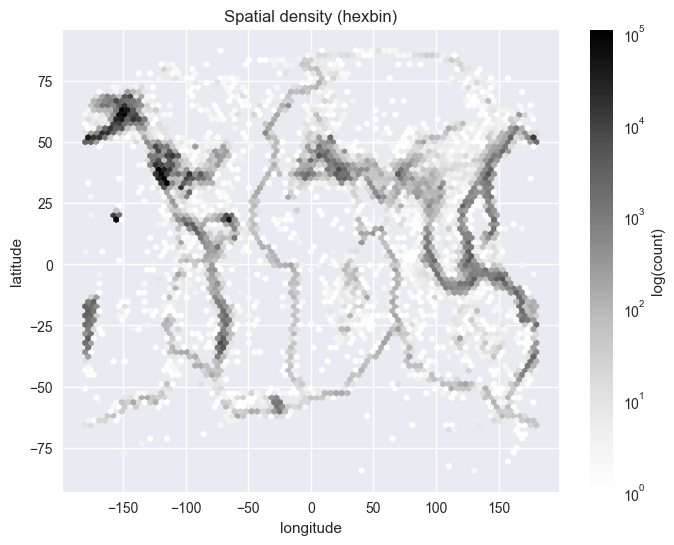

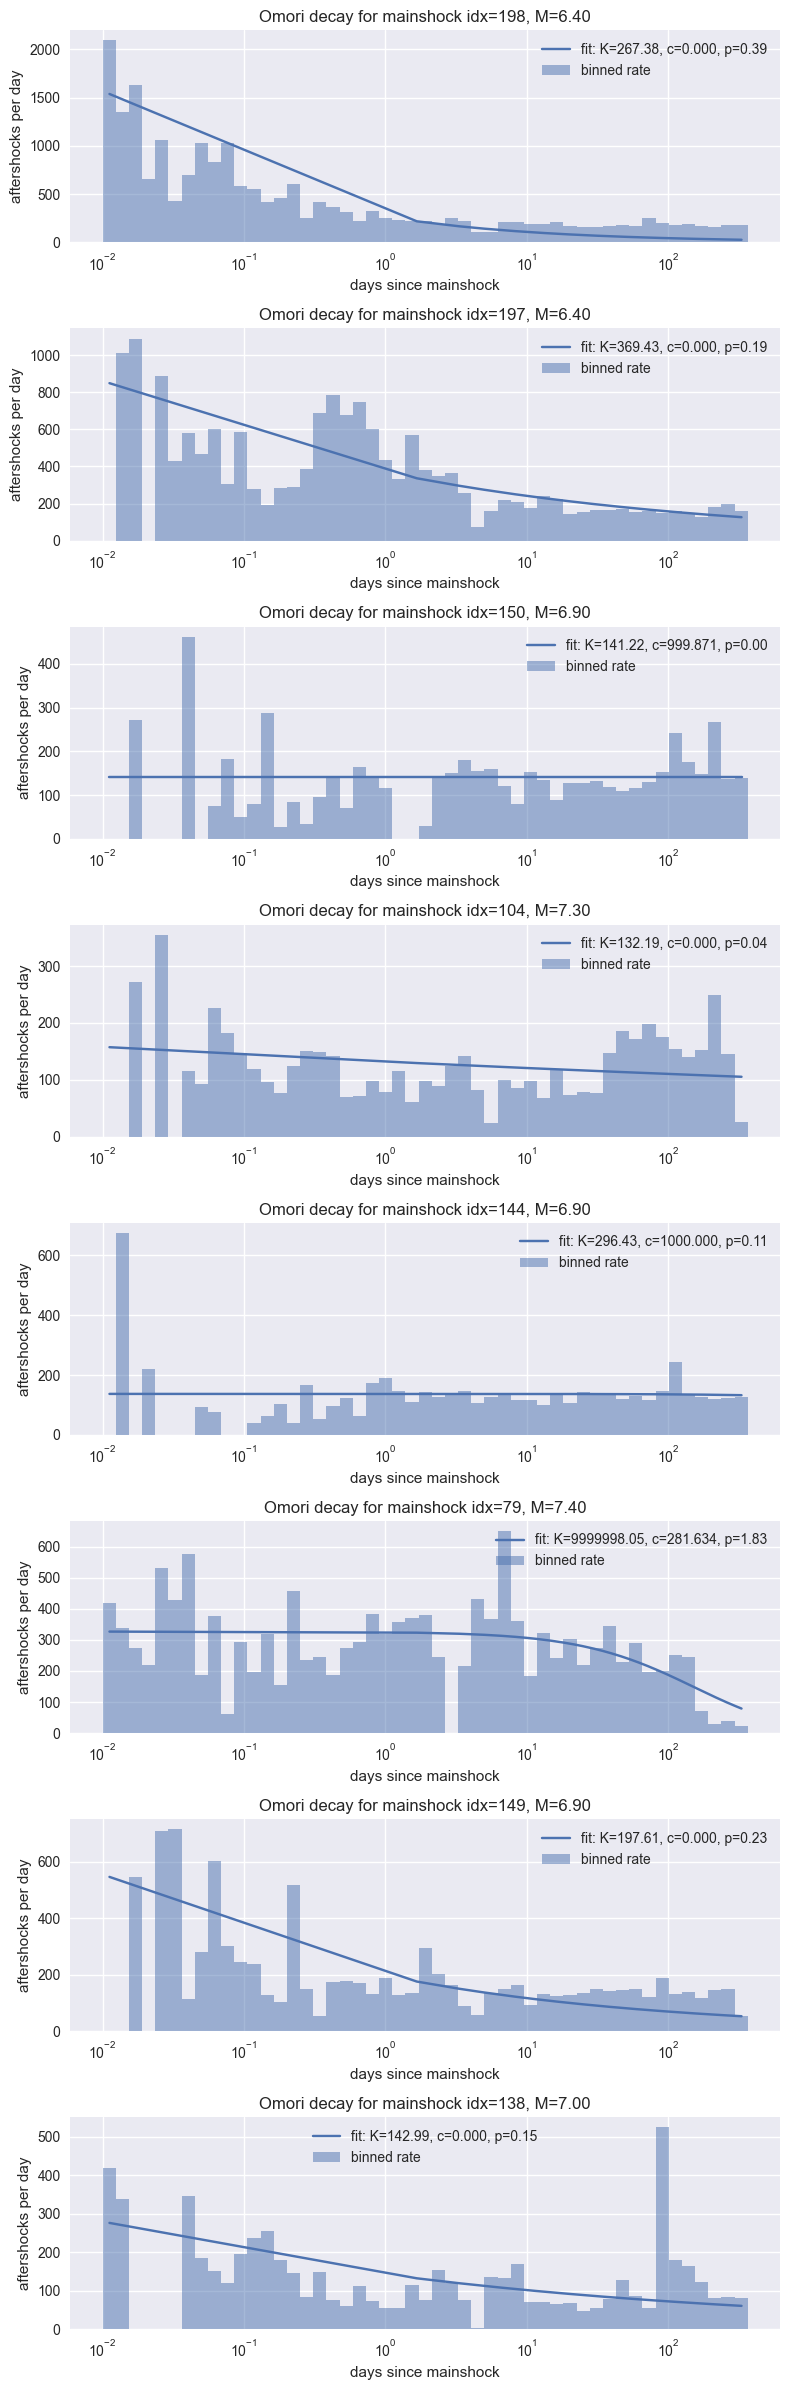


=== Comparison Summary ===
{'Mc': 1.0999999999999996,
 'b_value': 0.3509910187393669,
 'etas_K': 12.154803142979617,
 'etas_alpha': 0.0538267380006052,
 'etas_background_fraction': 0.2995035192364371,
 'etas_branching_ratio': 0.7350080582890733,
 'etas_mu': 59.24862218892068,
 'etas_omega': 19.49384164402668,
 'hawkes_alpha': 14.984920380210712,
 'hawkes_background_fraction': 0.01211751154875197,
 'hawkes_beta': 15.163968859820528,
 'hawkes_branching_ratio': 0.9881925054538832,
 'hawkes_mu': 2.397119958564228,
 'n_events_filtered': 1864823,
 'total_events': 2805526}

=== First 5 rows of assigned catalog (flags_df) ===


,id,mag,place,time,updated,felt,cdi,mmi,alert,status,tsunami,sig,nst,dmin,rms,gap,magType,type_property,title,longitude,latitude,depth,time_parsed,year,month,day,hour,country,inferred_country,mag_category,region_continent,mainshock_idx,is_aftershock
0,nc21075021,1.23,"5 km NE of East Foothills, California",2000-01-01 08:03:53.650,2016-12-31 11:48:51.007,NaN,NaN,NaN,NaN,reviewed,0,23,20.0,0.04414,0.040,78.0,md,earthquake,"M 1.2 - 5 km NE of East Foothills, California",-121.7665,37.416667,5.360,2000-01-01 08:03:53.650000+00:00,2000,1,1,8,California,California,Small (<3),Other,-1,False
1,usp0009kjv,1.90,"7 km W of Porirua, New Zealand",2000-01-01 08:04:49.400,2014-11-07 09:09:13.881,NaN,NaN,NaN,NaN,reviewed,0,56,NaN,NaN,NaN,NaN,ml,earthquake,"M 1.9 - 7 km W of Porirua, New Zealand",174.7600,-41.130000,27.000,2000-01-01 08:04:49.400000+00:00,2000,1,1,8,New Zealand,New Zealand,Small (<3),Other,-1,False
2,ci9131991,2.48,"7km WSW of Estacion Coahuila, B.C., MX",2000-01-01 08:20:00.020,2016-02-16 14:54:25.259,NaN,NaN,NaN,NaN,reviewed,0,95,0.0,0.57710,0.228,240.8,mc,earthquake,"M 2.5 - 7km WSW of Estacion Coahuila, B.C., MX",-115.0730,32.179000,5.933,2000-01-01 08:20:00.020000+00:00,2000,1,1,8,MX,MX,Small (<3),Other,-1,False
3,ak0001nth5v,1.40,"42 km WNW of Anchor Point, Alaska",2000-01-01 08:47:26.117,2020-02-21 04:06:41.139,NaN,NaN,NaN,NaN,reviewed,0,30,NaN,NaN,0.570,NaN,ml,earthquake,"M 1.4 - 42 km WNW of Anchor Point, Alaska",-152.5348,59.926000,89.400,2000-01-01 08:47:26.117000+00:00,2000,1,1,8,Alaska,Alaska,Small (<3),Other,-1,False
4,ci9131992,1.80,"23km SSW of Ludlow, California",2000-01-01 08:50:26.650,2016-02-17 15:04:03.213,NaN,NaN,NaN,NaN,reviewed,0,50,0.0,0.12780,0.119,79.1,mh,earthquake,"M 1.8 - 23km SSW of Ludlow, California",-116.2410,34.523000,10.747,2000-01-01 08:50:26.650000+00:00,2000,1,1,8,California,California,Small (<3),Other,-1,False



=== Hawkes temporal model fit (no magnitude) ===
  mu (background rate)          = 2.397120 events per day
  alpha (triggering strength)   = 14.984920
  beta (decay rate)             = 15.163969
  branching ratio (alpha/beta)  = 0.988193
  estimated background fraction = 0.012118
  total events (original)       = 2805526
  filtered events (>=Mc)        = 1864823

=== ETAS-like temporal model (with mag) ===
  mu (background rate)          = 59.248622 events per day
  K (productivity)              = 12.154803
  alpha (mag exponent)          = 0.053827
  omega (time decay)            = 19.493842
  branching ratio (triggered/N) = 0.735008
  estimated background fraction = 0.299504

=== Sequence summary (top rows) ===


,mainshock_idx,mag,n_aftershocks,R_km,Tmax_days,K,c,p,centroid_lat,centroid_lon,fit_success
198,198,6.4,66023,NaN,NaN,2.673776e+02,2.539478e-16,3.893313e-01,47.432398,-137.964096,True
197,197,6.4,61384,NaN,NaN,3.694306e+02,5.663491e-17,1.852329e-01,46.447466,-135.625024,True
150,150,6.9,59041,NaN,NaN,1.412196e+02,9.998710e+02,5.680227e-11,53.078370,-133.304243,True
104,104,7.3,49839,NaN,NaN,1.321888e+02,1.844567e-22,3.892150e-02,42.002173,-94.264792,True
144,144,6.9,49070,NaN,NaN,2.964318e+02,1.000000e+03,1.115016e-01,44.617828,-122.760054,True
79,79,7.4,47129,NaN,NaN,9.999998e+06,2.816343e+02,1.831167e+00,41.870977,-124.761190,True
149,149,6.9,45516,NaN,NaN,1.976099e+02,6.619019e-19,2.265813e-01,46.659230,-129.380211,True
138,138,7.0,44829,NaN,NaN,1.429937e+02,1.941278e-25,1.468908e-01,32.912122,-115.374098,True
124,124,7.1,44753,NaN,NaN,1.539918e+02,7.146234e-32,2.938460e-01,47.077132,-125.124345,True
158,158,6.8,42118,NaN,NaN,5.669405e+01,9.999821e+02,9.755133e-12,32.853882,-108.882126,True


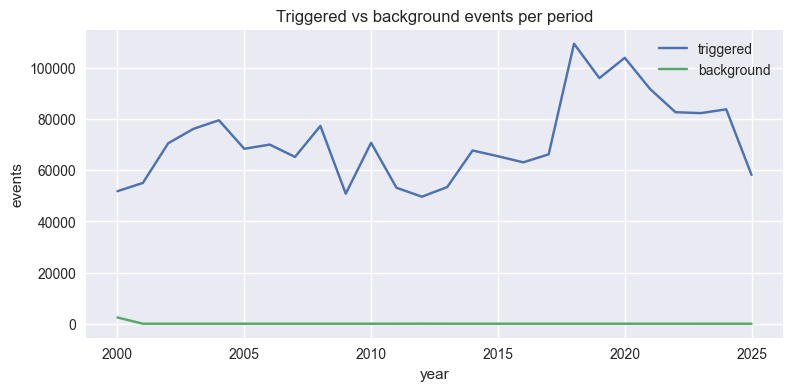


Done. Sequence summary is in variable seq_df, assigned catalog is flags_df.


In [17]:
# Code 2: Execution cell that calls compare_declustering_methods and shows outputs.

from pprint import pprint

if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Load your catalog into variable named df before running this cell.")

catalog = df  

required_cols = {'time', 'latitude', 'longitude', 'mag'}
missing = required_cols - set(catalog.columns)
if missing:
    print("Warning: catalog missing columns:", missing)

print("\nRunning compare_declustering_methods on df (Hawkes, ETAS-like, sequences)...")
summary, flags_df, seq_df = compare_declustering_methods(
    catalog,
    time_col='time',
    lat_col='latitude',
    lon_col='longitude',
    mag_col='mag',
    mc_method='maxcurvature',
    mag_cut=None,
    main_mag_thresh=4.5,
)

print("\n=== Comparison Summary ===")
pprint(summary)

print("\n=== First 5 rows of assigned catalog (flags_df) ===")
display(flags_df.head())

print("\n=== Hawkes temporal model fit (no magnitude) ===")
print(f"  mu (background rate)          = {summary['hawkes_mu']:.6f} events per day")
print(f"  alpha (triggering strength)   = {summary['hawkes_alpha']:.6f}")
print(f"  beta (decay rate)             = {summary['hawkes_beta']:.6f}")
print(f"  branching ratio (alpha/beta)  = {summary['hawkes_branching_ratio']:.6f}")
print(f"  estimated background fraction = {summary['hawkes_background_fraction']:.6f}")
print(f"  total events (original)       = {summary['total_events']}")
print(f"  filtered events (>=Mc)        = {summary['n_events_filtered']}")

print("\n=== ETAS-like temporal model (with mag) ===")
print(f"  mu (background rate)          = {summary['etas_mu']:.6f} events per day")
print(f"  K (productivity)              = {summary['etas_K']:.6f}")
print(f"  alpha (mag exponent)          = {summary['etas_alpha']:.6f}")
print(f"  omega (time decay)            = {summary['etas_omega']:.6f}")
print(f"  branching ratio (triggered/N) = {summary['etas_branching_ratio']:.6f}")
print(f"  estimated background fraction = {summary['etas_background_fraction']:.6f}")

print("\n=== Sequence summary (top rows) ===")
display(seq_df.sort_values('n_aftershocks', ascending=False).head(10))

# Plot triggered vs background events per year (use assigned flags)
if 'mainshock_idx' in flags_df.columns:
    try:
        df_ts = flags_df.copy()
        df_ts['triggered'] = df_ts['is_aftershock'].astype(int)
        df_ts['time'] = pd.to_datetime(df_ts['time'])
        freq = 'YE'  
        grp = df_ts.set_index('time').groupby(pd.Grouper(freq=freq))['triggered'].agg(['sum', 'count'])
        years = grp.index.year
        plt.figure(figsize=(9, 4))
        plt.plot(years, grp['sum'], label='triggered')
        plt.plot(years, grp['count'] - grp['sum'], label='background')
        plt.xlabel('year')
        plt.ylabel('events')
        plt.title('Triggered vs background events per period')
        plt.legend()
        plt.show()
    except Exception:
        pass

print("\nDone. Sequence summary is in variable seq_df, assigned catalog is flags_df.")
